<a href="https://colab.research.google.com/github/singhsukhendra/100-Days-Of-ML-Code/blob/master/Kaggle_Breast_Cancer_Classification_with_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import zipfile
with zipfile.ZipFile("/content/drive/MyDrive/breast-histopathology-images.zip","r") as zip_ref:
    zip_ref.extractall("breast-histopathology-images")

In [ ]:
import os
import glob
import random as rn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
from tensorflow.keras import models, layers
# Libraries for Transfer Learning
from tensorflow.keras.applications import DenseNet201
from keras.applications.densenet import preprocess_input

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import os
import shutil

from tensorflow.keras import Model
from tensorflow.keras.callbacks import Callback, TensorBoard, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Add, Dropout, ReLU, BatchNormalization, Input, Lambda
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import Recall, Precision, AUC
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
sns.set()
import tensorflow as tf

In [ ]:
PATH = '/content/breast-histopathology-images'
folders = os.listdir('/content/breast-histopathology-images')
folders.sort()
folders.remove('IDC_regular_ps50_idx5')

Few negative image of Pacitent ID 13404


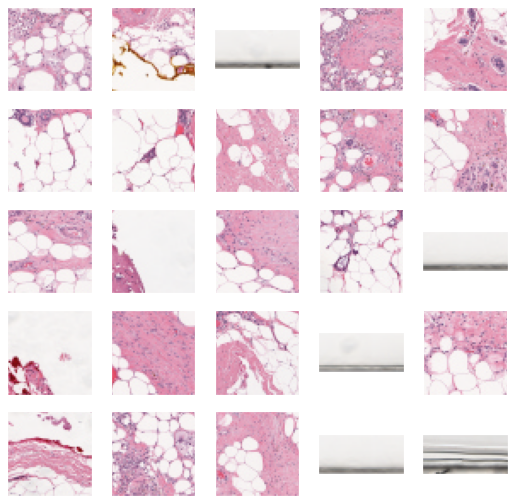

Few positive image of Pacitent ID 13404


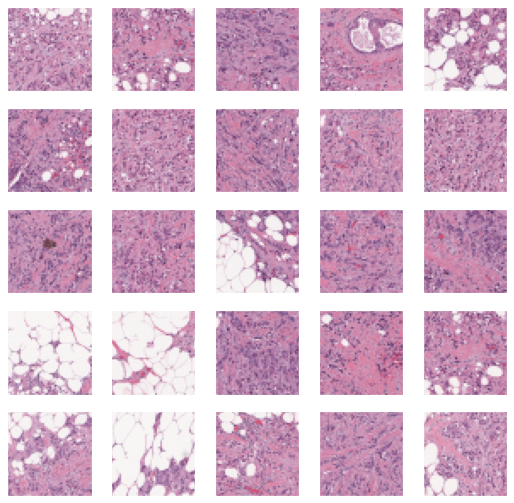

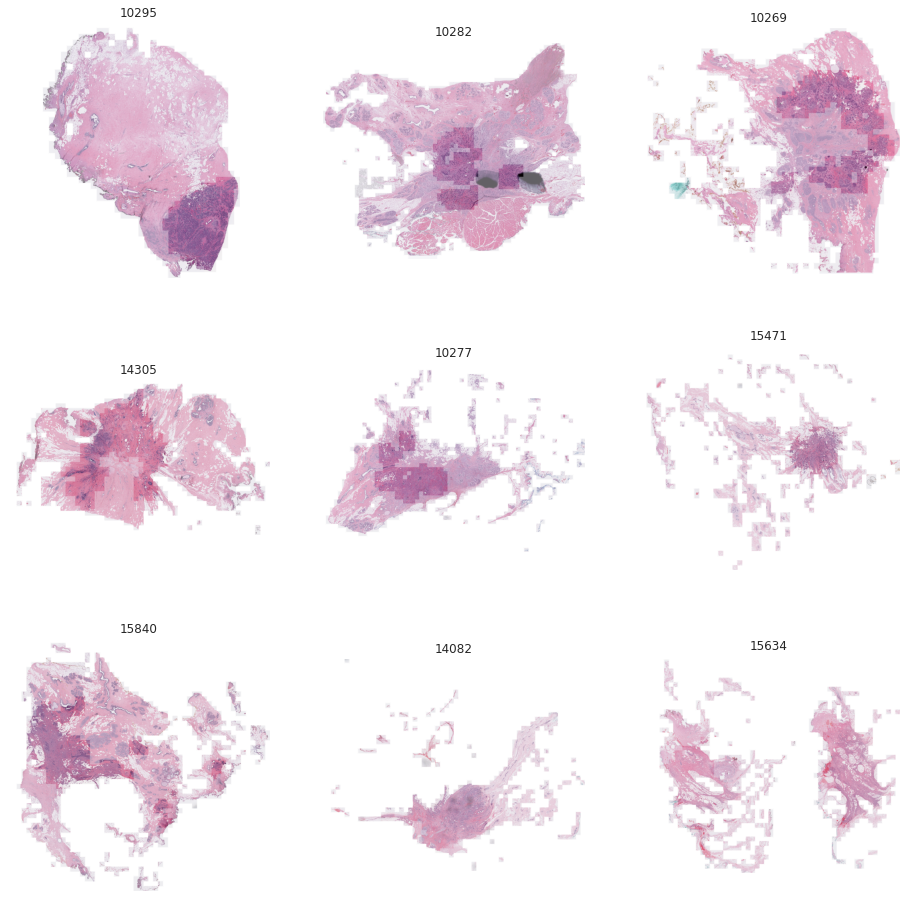

In [ ]:
def get_x_y(string):
    _, _, x, y, c = string.split('_')
    return [int(x[1:]), int(y[1:]), int(c[-5])]

def getImg(Pid):
    base = os.path.join(PATH, Pid)
    stringList = []
    stringList.extend(base + '/0/' + s for s in os.listdir(base + '/0'))
    stringList.extend(base + '/1/' + s for s in os.listdir(base + '/1'))
    length = len(stringList)

    index = np.zeros((length, 3), dtype = np.int32)
    smallImg = 255*np.ones((length, 50, 50, 3), dtype = np.int8)

    for i in range(length):
        index[i] = get_x_y(stringList[i])
        tempImg = Image.open(stringList[i])

        if tempImg.size != (50,50):
            smallImg[i, :tempImg.size[1], :tempImg.size[0]] = np.array(tempImg)
        else :
            smallImg[i] = np.array(tempImg)

    maxVal = np.max(index, axis = 0)
    fullImg = 255 * np.ones((maxVal[1] + 50, maxVal[0] + 50, 4), dtype = np.int8)
    for i in range(length):
        x, y, c = index[i]
        fullImg[y : y+50, x : x+50, :3] = smallImg[i]
        if c == 0:
            fullImg[y : y+50, x : x+50, 3] = 150
    return fullImg

def viewImg():
    idx = np.random.randint(0,high = len(folders))
    basePath = os.path.join(PATH, folders[idx])
    imgs0 = os.listdir(os.path.join(basePath, '0'))
    imgs1 = os.listdir(os.path.join(basePath, '1'))
    base0 = os.path.join(basePath,'0')
    base1 = os.path.join(basePath,'1')
    idx0 = np.random.choice(np.arange(len(imgs0)), size = 25)
    idx1 = np.random.choice(np.arange(len(imgs1)), size = 25)

    print('Few negative image of Pacitent ID ' + str(folders[idx]))
    plt.figure(figsize = [9,9])
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(Image.open(os.path.join(base0, imgs0[idx0[i]])))
    plt.show()

    print('Few positive image of Pacitent ID ' + str(folders[idx]))
    plt.figure(figsize = [9,9])
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(Image.open(os.path.join(base1, imgs1[idx1[i]])))
    plt.show()
viewImg()

def viewRandom9():
    idx = np.random.choice(np.arange(len(folders)) ,size = 9)
    plt.figure(figsize = [16,16])
    for i in range(9):
        plt.subplot(3,3, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.title(str(folders[idx[i]]))
        plt.imshow(getImg(folders[idx[i]]))

viewRandom9()

In [ ]:
def splitData(folders, trainingData, testData, valData):
    """
    folders : list of folders
    train/test/valDataFraction : fraction of train/test/valDataFraction
    """
    PATH = '/content/breast-histopathology-images'
    length = len(folders)
    """os.mkdir('/kaggle/temp')
    OutputPath = '/kaggle/temp'

    os.mkdir(os.path.join(OutputPath, 'train'))
    os.mkdir(os.path.join(OutputPath, 'test'))
    os.mkdir(os.path.join(OutputPath, 'val'))

    trainDir = os.path.join(OutputPath, 'train')
    testDir = os.path.join(OutputPath, 'test')
    valDir = os.path.join(OutputPath, 'val')

    os.mkdir(os.path.join(trainDir, '0'))
    os.mkdir(os.path.join(trainDir, '1'))
    trainDir0 = os.path.join(trainDir, '0')
    trainDir1 = os.path.join(trainDir, '1')

    os.mkdir(os.path.join(testDir, '0'))
    os.mkdir(os.path.join(testDir, '1'))
    testDir0 = os.path.join(testDir, '0')
    testDir1 = os.path.join(testDir, '1')

    os.mkdir(os.path.join(valDir, '0'))
    os.mkdir(os.path.join(valDir, '1'))
    valDir0 = os.path.join(valDir, '0')
    valDir1 = os.path.join(valDir, '1')
"""
    trainDF = valDF = testDF = pd.DataFrame(columns = ['img', 'lable'])
    index = np.arange(length)
    np.random.shuffle(index)

    for i in range(int(trainingData * length)):
        folder = os.path.join(PATH, folders[index[i]])
        src0 = os.path.join(folder, '0')
        src1 = os.path.join(folder, '1')

        lst0 = [os.path.join(src0, f) for f in os.listdir(src0)]
        lst1 = [os.path.join(src1, f) for f in os.listdir(src1)]
        df0 = pd.DataFrame(list(zip(lst0, np.zeros(len(lst0), dtype = np.int8))), columns = trainDF.columns)
        df1 = pd.DataFrame(list(zip(lst1, np.ones(len(lst1), dtype = np.int8))), columns = trainDF.columns)
        trainDF = trainDF.append(df0, ignore_index = True)
        trainDF = trainDF.append(df1, ignore_index = True)


    for i in range(int(trainingData * length), int((testData + trainingData)* length)):
        folder = os.path.join(PATH, folders[index[i]])
        src0 = os.path.join(folder, '0')
        src1 = os.path.join(folder, '1')


        lst0 = [os.path.join(src0, f) for f in os.listdir(src0)]
        lst1 = [os.path.join(src1, f) for f in os.listdir(src1)]
        df0 = pd.DataFrame(list(zip(lst0, np.zeros(len(lst0), dtype = np.int8))), columns = trainDF.columns)
        df1 = pd.DataFrame(list(zip(lst1, np.ones(len(lst1), dtype = np.int8))), columns = trainDF.columns)
        valDF = valDF.append(df0, ignore_index = True)
        valDF = valDF.append(df1, ignore_index = True)

    for i in range(int((testData + trainingData)* length), length):
        folder = os.path.join(PATH, folders[index[i]])
        src0 = os.path.join(folder, '0')
        src1 = os.path.join(folder, '1')

        lst0 = [os.path.join(src0, f) for f in os.listdir(src0)]
        lst1 = [os.path.join(src1, f) for f in os.listdir(src1)]
        df0 = pd.DataFrame(list(zip(lst0, np.zeros(len(lst0), dtype = np.int8))), columns = trainDF.columns)
        df1 = pd.DataFrame(list(zip(lst1, np.ones(len(lst1), dtype = np.int8))), columns = trainDF.columns)
        testDF = testDF.append(df0, ignore_index = True)
        testDF = testDF.append(df1, ignore_index = True)

    trainDF['lable'] = trainDF['lable'].astype('str')
    valDF['lable'] = valDF['lable'].astype('str')
    testDF['lable'] = testDF['lable'].astype('str')

    print(trainDF.info())
    print(valDF.info())
    print(testDF.info())
    return trainDF, valDF, testDF


trainDF, valDF, testDF = splitData(folders, 0.8, 0.1, 0.1)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227975 entries, 0 to 227974
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   img     227975 non-null  object
 1   lable   227975 non-null  object
dtypes: object(2)
memory usage: 3.5+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23450 entries, 0 to 23449
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   img     23450 non-null  object
 1   lable   23450 non-null  object
dtypes: object(2)
memory usage: 366.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26099 entries, 0 to 26098
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   img     26099 non-null  object
 1   lable   26099 non-null  object
dtypes: object(2)
memory usage: 407.9+ KB
None


In [ ]:
logdir = 'logs'

class My_callback(Callback):
    def on_epoch_end(self, epoch, logs = {}):
        if (logs['acc'] > 0.93):
            self.model.stop_training = True

esCallback = EarlyStopping(monitor = 'acc', patience = 3)
mcCallback = ModelCheckpoint(filepath = 'modelOn.hdf5', monitor = 'val_loss', save_best_only = True)
lrCallback = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 3)
tbCallback = TensorBoard(log_dir = logdir)
csCallback = My_callback()

In [ ]:
 trainDataGen = ImageDataGenerator(rescale = 1./255,
                                 horizontal_flip = True,
                                 vertical_flip = True)
valDataGen = ImageDataGenerator(rescale = 1./255)

trainFlow = trainDataGen.flow_from_dataframe(trainDF, x_col = 'img', y_col = 'lable',
                                             class_mode = 'binary',
                                             target_size = (50,50),
                                             validate_filenames = False)

valFlow = valDataGen.flow_from_dataframe(valDF, x_col = 'img', y_col = 'lable',
                                         class_mode = 'binary',
                                         target_size = (50,50),
                                         validate_filenames = False)

testFlow = valDataGen.flow_from_dataframe(testDF, x_col = 'img', y_col = 'lable',
                                          class_mode = 'binary',
                                          target_size = (50,50),
                                          validate_filenames = False)

Found 227975 non-validated image filenames belonging to 2 classes.
Found 23450 non-validated image filenames belonging to 2 classes.
Found 26099 non-validated image filenames belonging to 2 classes.


In [ ]:
def resNet(layer, filterIn, filterOut, conv, block, isFirst):

    if isFirst:
        x = Conv2D(filterIn, (1,1), (2,2), name = conv + '_' + block + '_1')(layer)
        x = BatchNormalization(name = conv + '_' + block + '_1_' + 'Norm', trainable = True)(x)
        x = ReLU(name = conv + '_' + block + '_1_' + 'ReLU')(x)

        x = Conv2D(filterIn, (3,3), padding='same', name = conv + '_' + block + '_2')(x)
        x = BatchNormalization(name = conv + '_' + block + '_2_' + 'Norm', trainable = True)(x)
        x = ReLU(name = conv + '_' + block + '_2_' + 'ReLU')(x)

        x = Conv2D(filterOut, (1,1), name = conv + '_' + block + '_3')(x)
        x = BatchNormalization(name = conv + '_' + block + '_3_' + 'Norm', trainable = True)(x)

        y = Conv2D(filterOut,(1,1), (2,2), name = conv + '_' + block + '_0')(layer)
        y = BatchNormalization(name = conv + '_' + block + '_0_' + 'Norm', trainable = True)(y)

    else:
        x = Conv2D(filterIn, (1,1), name = conv + '_'+ block + '_1')(layer)
        x = BatchNormalization(name = conv + '_' + block + '_1_' + 'Norm', trainable = True)(x)
        x = ReLU(name = conv + '_' + block + '_1_' + 'ReLU')(x)

        x = Conv2D(filterIn, (3,3), name = conv + '_'+ block + '_2', padding='same')(x)
        x = BatchNormalization(name = conv + '_' + block + '_2_' + 'Norm', trainable = True)(x)
        x = ReLU(name = conv + '_' + block + '_2_' + 'ReLU')(x)

        x = Conv2D(filterOut, (1,1), name = conv + '_'+ block + '_3')(x)
        x = BatchNormalization(name = conv + '_' + block + '_3_' + 'Norm', trainable = True)(x)

        y = layer

    out = Add()([x,y])
    out = ReLU(name = conv + '_' + block + '_final_' + 'ReLU')(out)
    return out

def resNetAll(blockFilter, nosOfblock, layer_):
    x = layer_
    for i in range(len(blockFilter)-1):
        for j in range(nosOfblock[i]):
            if j == 0:
                x = resNet(x, blockFilter[i], blockFilter[i+1], 'conv' + str(i+1), 'block' + str(j+1), True)
            else:
                x = resNet(x, blockFilter[i], blockFilter[i+1], 'conv' + str(i+1), 'block' + str(j+1), False)

    return x


inputs = (None, None, 3)
inp = Input(inputs)
x = Conv2D(16, (3,3), padding= 'same', name = 'InitialInput')(inp)
x = BatchNormalization(name = 'InitialBatch',trainable = True)(x)
x = ReLU(name = 'InitialReLU')(x)
x = resNetAll([32, 32, 64, 64], [3,5,5], x)
x = Conv2D(512, (7,7))(x)
x = BatchNormalization(trainable = True)(x)
x = ReLU()(x)
x = Conv2D(16, (1,1))(x)
x = BatchNormalization(trainable = True)(x)
x = ReLU()(x)
x = Conv2D(1, (1,1), activation = 'sigmoid')(x)
x = Lambda(lambda x: K.reshape(x,shape =  [-1, 1]))(x)
model = Model(inp, x)
model.compile('adam','binary_crossentropy' ,['acc','mse', Precision(), Recall(), AUC(),])


In [ ]:
totalOnes = np.sum(trainDF['lable'].astype('int'))
totalZeros = len(trainDF) - totalOnes
zeroClass, oneClass = totalOnes/ (totalOnes + totalZeros), totalZeros / (totalOnes + totalZeros)
weightDist = {0 : zeroClass, 1 : oneClass}

In [ ]:
print(totalOnes)
print(totalZeros)

63259
164716


In [ ]:
history = model.fit(trainFlow,
                   epochs = 40,
                   callbacks = [tbCallback,csCallback, lrCallback, esCallback, mcCallback],
                   class_weight = weightDist,
                   steps_per_epoch = 2000,
                   validation_data = valFlow,
                )
model.save('/content/model.h5')

Epoch 1/40
2000/2000 [==============================] - 122s 55ms/step - loss: 0.1784 - acc: 0.8031 - mse: 0.1418 - precision: 0.6084 - recall: 0.7980 - auc: 0.8721 - val_loss: 0.6204 - val_acc: 0.8020 - val_mse: 0.1648 - val_precision: 0.8477 - val_recall: 0.3342 - val_auc: 0.7912
Epoch 2/40
2000/2000 [==============================] - 79s 40ms/step - loss: 0.1535 - acc: 0.8268 - mse: 0.1235 - precision: 0.6414 - recall: 0.8560 - auc: 0.9087 - val_loss: 1.0096 - val_acc: 0.7646 - val_mse: 0.2089 - val_precision: 0.9364 - val_recall: 0.1473 - val_auc: 0.6941
Epoch 3/40
2000/2000 [==============================] - 79s 39ms/step - loss: 0.1474 - acc: 0.8366 - mse: 0.1175 - precision: 0.6618 - recall: 0.8643 - auc: 0.9166 - val_loss: 0.8645 - val_acc: 0.7788 - val_mse: 0.1956 - val_precision: 0.8954 - val_recall: 0.2140 - val_auc: 0.7452
Epoch 4/40
2000/2000 [==============================] - 77s 38ms/step - loss: 0.1430 - acc: 0.8411 - mse: 0.1142 - precision: 0.6638 - recall: 0.8634 - a

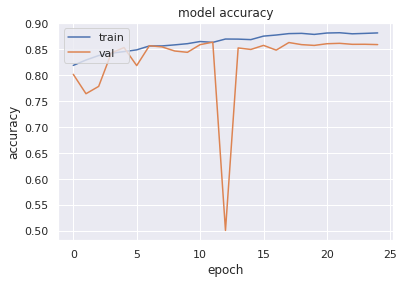

In [ ]:
plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

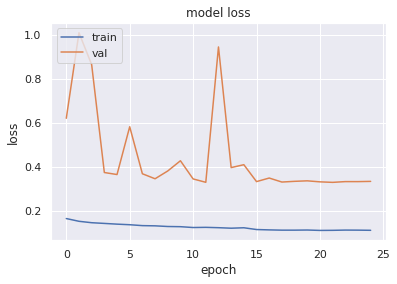

In [ ]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

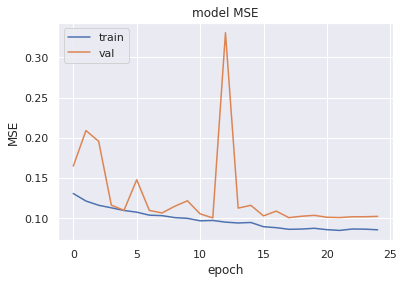

In [ ]:
plt.figure()
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

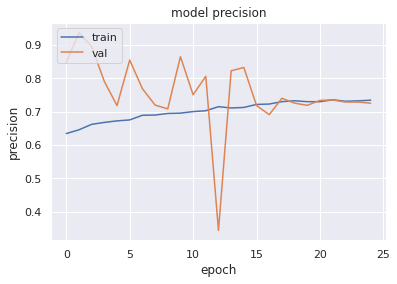

In [ ]:
plt.figure()
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

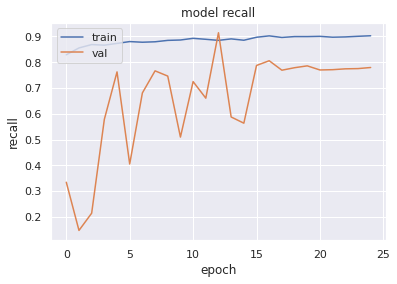

In [ ]:
plt.figure()
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

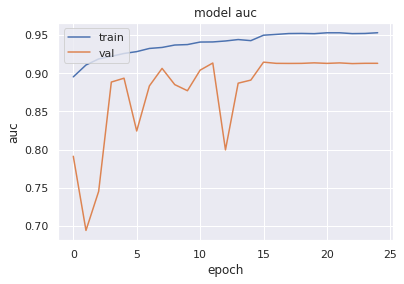

In [ ]:
plt.figure()
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [ ]:
res = model.evaluate(testFlow)
print("Model loss      on testDataset " + str(res[0]))
print("Model acc       on testDataset " + str(res[1]))
print("Model mse       on testDataset " + str(res[2]))
print("Model precision on testDataset " + str(res[3]))
print("Model recall    on testDataset " + str(res[4]))
print("Model AUC       on testDataset " + str(res[5]))

816/816 [==============================] - 22s 27ms/step - loss: 0.3089 - acc: 0.8699 - mse: 0.0948 - precision: 0.8057 - recall: 0.8278 - auc: 0.9363
Model loss      on testDataset 0.3089272081851959
Model acc       on testDataset 0.8699184060096741
Model mse       on testDataset 0.09479045122861862
Model precision on testDataset 0.8056710362434387
Model recall    on testDataset 0.827820360660553
Model AUC       on testDataset 0.9363193511962891


In [ ]:
def preprocess_data(img_path):
    img = cv2.imread(img_path,  cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (196, 196))
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    img = img/255.0
    img = np.reshape(img, (196,196,3))

    return img

def load_dataset(df):
    print("[INFO] Loading images ...")
    data = []
    labels = []

    for img_path, label in df.values:
        data.append(preprocess_data(img_path))
        labels.append(label)

    print("SUCCESSFULLY")
    return np.array(data), np.array(labels)

In [ ]:
X_train, y_train = load_dataset(trainDF)
X_test, y_test = load_dataset(testDF)
X_val, y_val = load_dataset(valDF)

print('Train data shape : {}, Labels shape : {}'.format(X_train.shape, y_train.shape))
print('Test data shape : {}, Labels shape : {}'.format(X_test.shape, y_test.shape))
print('Validation data shape : {}, Labels shape : {}'.format(X_val.shape, y_val.shape))

[INFO] Loading images ...


In [ ]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

In [ ]:
# define generator
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range = 0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False
)

# fit generator on our train features
datagen.fit(X_train)

In [ ]:
print("Summary of default DenseNet201.\n")
model_densenet=DenseNet201(weights='imagenet')
# initializing model with weights='imagenet'i.e. we are carring its original weights


# display the summary to see the properties of the model
model_densenet.summary()

In [ ]:
img_width = 196
img_height = 196

print("Summary of Custom VGG16 model.\n")
print("1) We setup input layer and 2) We removed top (last) layer. \n")

# let us prepare our input_layer to pass our image size. default is (224,224,3). we will change it to (196,196,3)
input_layer=layers.Input(shape=(img_width,img_height,3))

# initialize the transfer model VGG16 with appropriate properties per our need.
# we are passing paramers as following
# 1) weights='imagenet' - Using this we are carring weights as of original weights.
# 2) input_tensor to pass the VGG16 using input_tensor
# 3) we want to change the last layer so we are not including top layer
model_densenet=DenseNet201(weights='imagenet',input_tensor=input_layer,include_top=False)

# See the summary of the model with our properties.
model_densenet.summary()

In [ ]:
print("Summary of Custom VGG16 model.\n")
print("1) We flatten the last layer and added 1 Dense layer and 1 output layer.\n")

last_layer=model_densenet.output # we are taking last layer of the model

# Add flatten layer: we are extending Neural Network by adding flattn layer
flatten=layers.Flatten()(last_layer)

# Add dense layer
# dense1=layers.Dense(100,activation='relu')(flatten)

# Add dense layer to the final output layer
output_layer=layers.Dense(2,activation='softmax')(flatten)

# Creating modle with input and output layer
model=models.Model(inputs=input_layer,outputs=output_layer)

# Summarize the model
model.summary()

In [ ]:
# we are making all the layers intrainable except the last layer
print("We are making all the layers intrainable except the last layer. \n")
for layer in model.layers[:-1]:
    layer.trainable=False
model.summary()

In [ ]:
optimizer = Adam(lr=0.0001, decay=1e-5)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

callback = EarlyStopping(monitor='loss', patience=8)

history = model.fit(datagen.flow(X_train,y_train, batch_size=4),
                    validation_data=(X_test, y_test),
                    epochs = 50,
                    verbose = 1,
                    callbacks=[callback],
                    class_weight={0:6.0, 1:0.5})

In [ ]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, verbose=0)
print("Test Loss, Test Acc:", results)

In [ ]:
plt.figure(figsize=(20,5))

# plot loss & val loss
plt.subplot(1,2,1)
sns.lineplot(x=history.epoch, y=history.history['loss'], color='red', label='Loss')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], color='orange', label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Vs Validation Loss')
plt.legend(loc='best')

# plot accuracy and val accuracy
plt.subplot(1,2,2)
sns.lineplot(x=history.epoch, y=history.history['accuracy'], color='blue', label='Accuracy')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], color='green', label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Vs Validation Accuracy ')
plt.legend(loc='best')

plt.show()

In [ ]:
#Confusion Matrix on test data
y_test_hat = model.predict(X_test, batch_size=4)
y_test_hat = np.argmax(y_test_hat, axis=1)
y_test = np.argmax(y_test, axis=1)

In [ ]:
conf_m = confusion_matrix(y_test, y_test_hat)
clas_r = classification_report(y_test, y_test_hat)

# plot confusion matrix as heatmap
plt.figure(figsize=(5,3))
sns.set(font_scale=1.2)
ax = sns.heatmap(conf_m, annot=True,xticklabels=['H', 'COV'], yticklabels=['H', 'COV'], cbar=False, cmap='Blues',linewidths=1, linecolor='black', fmt='.0f')
plt.yticks(rotation=0)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion matrix - Test data\n(H - Healthy/Normal, COV - COVID-19)\n')
plt.show()

# print classification report
print('\nClassification report on Test data :\n')
print(clas_r)

In [ ]:
pred_prob = model.predict(X_test)

# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(y_test, pred_prob[:,1], pos_label=1)

# roc curve for tpr = fpr
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

# auc score
auc_score = roc_auc_score(y_test, pred_prob[:,1])

print('AUC Score : ',auc_score)

In [ ]:
# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='red', label='VGG16 Model')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

In [ ]:
#Validation Data
#First predict labels and get them to 1D array
y_val_hat = model.predict(X_val, batch_size=4)
y_val_hat = np.argmax(y_val_hat, axis=1)
y_val = np.argmax(y_val, axis=1)

In [ ]:
#Show images, real & predicted labels
plt.figure(figsize=(20,15))
for i,x in enumerate(X_val):
    plt.subplot(4,4,i+1)
    plt.imshow(x.reshape(196, 196,3), cmap='gray')
    plt.axis('off')

    if y_val_hat[i] == y_val[i]: #setting up label color
        color='darkgreen' # if prediction is correct then green color
    else:
        color='red' # wrong then red colour

    plt.title('Predicted: {}, Real: {}'.format(y_val_hat[i], y_val[i]), color=color)

In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np
import json
import glob
import os
import os
import cv2
import glob
import numpy as np
import pandas as pd
import random
import pickle
from tqdm import tqdm
from pathlib import Path
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mlxtend.plotting import plot_confusion_matrix
from scipy import ndimage
import skimage
from skimage.io import imread
from skimage.transform import resize
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedShuffleSplit as s_split
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense , Activation
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD , RMSprop, Adam
from keras.layers import Conv2D , SeparableConv2D, BatchNormalization, UpSampling2D, MaxPool2D
from keras.layers import MaxPooling2D, Average, Input, Concatenate, LeakyReLU, Add, ELU, PReLU, ReLU
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau , ModelCheckpoint
from keras.utils.np_utils import to_categorical
from keras import backend as BE
#from vis.visualization import visualize_cam, visualize_cam_with_losses, visualize_activation, visualize_saliency
from vis.utils import utils
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.xception import Xception
from keras.applications.resnet50 import ResNet50
from keras.layers import GlobalAveragePooling2D
from keras.models import Model
from keras.utils import plot_model
from numpy.random import seed
#from tensorflow import set_random_seed


In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("VGG16_model.json", "w") as json_file:
    json_file.write(model_json)
print("Saved JSON model to disk")
# serialize weights to HDF5
model.save_weights("VGG16_model.hdf5")
print("Saved HDF5 model to disk")
# serialize model to H5
model.save("VGG16_model.h5")
print("Saved H5 model to disk")